## Introduction ##

The objective of this notebook is to build an automated human activity recognition system. Main goal is to obtain highest cross-validated activity prediction performance by applying various data preprocessing and machine learning methods and tuning their parameters.

Labeled human acitivity used in this study is publicly available on Kaggle[1].

Throughout this workbook, I will follow an iterative process where I will go back and forward to apply various data visualization, data preprocessing and model-training methods while paying special attention on:
- training time,
- testing time,
- prediction performance

My goal is, eventually, to learn more about the nature of the problem of activity recognition. I will mostly have an application developer view when I discuss the real life implications of the obtained results.

[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21st European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013 [ https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones ]

In [209]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

class_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

X_train = pd.read_csv('train.csv')
s_train = X_train['subject']
X_train.drop('subject', axis = 1, inplace = True)
y_train = X_train['Activity'].to_frame().reset_index()
X_train.drop('Activity', axis = 1, inplace = True)
y_train = y_train.replace(class_labels, [0, 1, 2, 3, 4, 5])

X_test = pd.read_csv('test.csv')
s_test = X_test['subject']
X_test.drop('subject', axis = 1, inplace = True)
y_test = X_test['Activity'].to_frame().reset_index()
X_test.drop(['Activity'], axis = 1, inplace = True)
y_test = y_test.replace(class_labels, [0, 1, 2, 3, 4, 5])

#NOTE: this contenation method (viz. append) is safer than concat
X = X_train.append(X_test, ignore_index=True)
y = y_train.append(y_test, ignore_index=True)

display(X.describe())
# display(y.describe())

#NOTE: append can adjust the index value of the appended dataframe whereas concatenation cannot. Concatenation may
#result in duplicate indices.
# dataframes = [X_train, X_test]
# X = pd.concat(dataframes)
# dataframes = [y_train, y_test]
# y = pd.concat(dataframes)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Iteration 1: Comparison of baseline classifiers ##

Before going into a more detailed work on the features and model training and testing, I will apply some of the supervised machine learning methods to have some idea about the baseline performance of those methods.

In [210]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from time import time

from sklearn.metrics import classification_report

def train(clf, features, target):
    start = time()
    clf.fit(features, target)
    end = time()
    return end - start

def predict(clf, features):
    start = time()
    pred = clf.predict(features)
    end = time()
    return end - start, pred

clf_SGD = SGDClassifier(random_state = 42)
clf_Ada = AdaBoostClassifier(random_state = 42)
clf_DTR = DecisionTreeRegressor(random_state=42)
clf_KNC = KNeighborsClassifier()
clf_GNB = GaussianNB()
clf_SVM = SVC()

clfs = {clf_SGD, clf_Ada, clf_DTR, clf_KNC, clf_GNB, clf_SVM}

y_train_ = y_train['Activity']
y_test_ = y_test['Activity']
y_ = y['Activity']

for clf in clfs:
    printout = ""
    if clf == clf_SGD: printout = "SGD"
    elif clf == clf_Ada: printout = "Ada"
    elif clf == clf_DTR: printout = "DTR"
    elif clf == clf_KNC: printout = "KNC"
    elif clf == clf_GNB: printout = "GNB"
    elif clf == clf_SVM: printout = "SVM"

    results_precision = []
    results_recall = []
    results_fscore = []
    results_ttrain = []
    results_ttest = []
    kfold = cross_validation.KFold(X.shape[0], n_folds=10, shuffle=False, random_state=42)
    for train, test in kfold:
        start = time()
        clf.fit(X.iloc[train], y_[train])
        results_ttrain.append(time()-start)
        #NOTE: for some resason this line doesn't work.
#         t_train = train(clf, X.iloc[train], y_[train])
        t_test, y_pred = predict(clf, X.iloc[test])
        results_ttest.append(t_test)
        precision, recall, fscore, support = precision_recall_fscore_support(y_[test], y_pred, average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)        
        
    printout += "  precision: {:.2f}".format(np.mean(results_precision))
    printout += "  recall: {:.2f}".format(np.mean(results_recall))
    printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
    printout += "  t_train: {:.4f}sec".format(np.mean(results_ttrain))
    printout += "  t_pred: {:.4f}sec".format(np.mean(results_ttest))
    print printout

Ada  precision: 0.37  recall: 0.54  fscore: 0.41  t_train: 30.7883sec  t_pred: 0.0327sec
SVM  precision: 0.94  recall: 0.94  fscore: 0.93  t_train: 9.9674sec  t_pred: 2.4073sec
DTR  precision: 0.88  recall: 0.87  fscore: 0.87  t_train: 5.2582sec  t_pred: 0.0018sec
GNB  precision: 0.80  recall: 0.73  fscore: 0.72  t_train: 0.1850sec  t_pred: 0.0442sec
SGD  precision: 0.95  recall: 0.94  fscore: 0.94  t_train: 0.3548sec  t_pred: 0.0027sec
KNC  precision: 0.91  recall: 0.91  fscore: 0.91  t_train: 0.6801sec  t_pred: 8.8861sec


## Iteration 2: Having a closer look at the features ##

SVM and SGD have the highest precision, recall and f1-score. SGD is the quickest in prediction and second quickest in training. I will be using SVM as the main method to build this action recognition system **[NOTE: EXPLAIN WHY]**.  

Although the cross-validated prediction performance is high already, there still might be potential improvement opportunities. For instance, removing the outliers is one way to improve the model. We can't visualize a 561-dimensional space in a human readable form but we can still have a look at how the features are distributed individually. I will plot the distribution of some of the features below.

Moreover, some of the features might be redundant. Redundant features can easily be distinguished by investigating the correlation between them and the other features. If there is high correlation with other features that means there is no reason to carry this feature as the information represented by this feature is already conveyed through other features.

Therefore, correlation matrix will allow us to see the distribution of the feature values individually and correlation between the features as shown below. I will use SelectKBest method to choose a subset of features for further investigation. In order to decide on the number **K**, I will run an exhaustive training batch where I change the number **K** and monitor che change in the cross-validated prediction performance of the SVM model.

In [211]:
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline

d_kbest_to_precision = {}
d_kbest_to_recall = {}
d_kbest_to_f1score = {}

kbest_max = X.shape[1]/4
clf = clf_SVM

for kbest in range (2, kbest_max):
    f_selector = SelectKBest(k=kbest)
    Xs = f_selector.fit(X, y_).transform(X)
    printout = "kbest: {:3d}".format(kbest)

    results_precision = []
    results_recall = []
    results_fscore = []
    results_ttrain = []
    results_ttest = []
    kfold = cross_validation.KFold(Xs.shape[0], n_folds=4, shuffle=False, random_state=42)
    for train, test in kfold:
        start = time()
        clf.fit(Xs[train], y_[train])
        results_ttrain.append(time()-start)
        #NOTE: for some resason this line doesn't work.
#         t_train = train(clf, X.iloc[train], y_[train])
        t_test, y_pred = predict(clf, Xs[test])
        results_ttest.append(t_test)
        precision, recall, fscore, support = precision_recall_fscore_support(y_[test], y_pred, average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)        
        
    printout += "  precision: {:.2f}".format(np.mean(results_precision))
    printout += "  recall: {:.2f}".format(np.mean(results_recall))
    printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
    printout += "  t_train: {:.3f}sec".format(np.mean(results_ttrain))
    printout += "  t_pred: {:.3f}sec".format(np.mean(results_ttest))
    print printout
    
    d_kbest_to_precision[kbest]=np.mean(results_precision)
    d_kbest_to_recall[kbest]=np.mean(results_recall)
    d_kbest_to_f1score[kbest]=np.mean(results_fscore)

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.grid(True)
major_ticks = np.arange(0, kbest_max, 20) 
minor_ticks = np.arange(0, kbest_max, 5)

# ax.set_xticks(major_ticks)                                                       
# ax.set_xticks(minor_ticks, minor=True) 
plt.xticks(minor_ticks)
plt.plot(d_kbest_to_precision.keys(), d_kbest_to_precision.values(), 'r',
        d_kbest_to_recall.keys(), d_kbest_to_recall.values(), 'g',
        d_kbest_to_f1score.keys(), d_kbest_to_f1score.values(), 'b')
plt.show()

Precision, recall and fscore values are calculated based on the class weighted average as there is imbalance between the number of class labels in the dataset  
496 WALKING,   
471 WALKING_UPSTAIRS,   
420 WALKING_DOWNSTAIRS,  
491 SITTING,  
532 STANDING,  
537 LAYING   

I will consider the best 16 features to further investigate. This is where the classification scores peak for the first time, and it doesn't change that much after that point on.**[NOTE: ADD LEGEND TO THE PLOT]**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline

kbest_selected = 16
f_selector = SelectKBest(k=kbest_selected)
f_selector.fit(X, y['Activity'])
f_selected_indices = f_selector.get_support(indices=False)
Xs_cols = X.columns[f_selected_indices]
Xs = X[Xs_cols] # dataset with selected features
# display(Xs.describe())

Having normally distributed features is the fundamental assumption in many predictive models. Normal distribution is un-skewed. It means the probability of falling in the right or left side of the mean is equally likely. As we can see from the correlation matrix above, and the skewness test below, these features are quite skewed, even mostly bimodal. **[NOTE: FURTHER DISCUSSION IS NEEDED]**

In [215]:
import scipy.stats.stats as st
skness = st.skew(X)

d_feature2skew = {}
for skew, feature in zip(skness , X.columns.values.tolist()):
    d_feature2skew[feature]=skew
    
feature2skew = sorted(d_feature2skew.items(), key=operator.itemgetter(1), reverse=True)
# for key, value in feature2skew:
#     print str(value) + " " + str(key)

In [ ]:
import numpy as np

# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(Xs, alpha = 0.3, figsize = (20,32), diagonal = 'kde')

# Reformat data.corr() for plotting
corr = Xs.corr().as_matrix()

# Plot scatter matrix with correlations
for i,j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i,j].annotate("%.2f"%corr[i,j], (0.1,0.25), xycoords='axes fraction', color='red', fontsize=16)

Skewness greater than zero shows a positively skewed distribution, while lower than zero shows a negatively skewed distribution. Replacing the data with the log, square root, or inverse may help to remove the skew. However, feature values of the current dataset with selected features change between -1 and 1. Therefore, sqrt and log is not applicable. If we apply any of those transformations, most of the feature values will turn into NaN and dataset will be useless.

To avoid this we first shift data to a non-negative range, then apply the non-linear transformation, after that scale it back to -1 and 1 to be able to compare the change in the feature distribution with bare eyes. If all go right, we should be able to see less skewed feature distribution.

In addition to sqrt-ing and log-ing, I will also try boxcox-ing to reduce the skewness.

kbest:   2  precision: 0.73  recall: 0.69  fscore: 0.67  t_train: 0.664sec  t_pred: 0.385sec
kbest:   3  precision: 0.73  recall: 0.70  fscore: 0.68  t_train: 0.653sec  t_pred: 0.391sec
kbest:   4  precision: 0.74  recall: 0.70  fscore: 0.69  t_train: 0.708sec  t_pred: 0.401sec
kbest:   5  precision: 0.73  recall: 0.70  fscore: 0.68  t_train: 0.710sec  t_pred: 0.417sec
kbest:   6  precision: 0.74  recall: 0.72  fscore: 0.70  t_train: 0.675sec  t_pred: 0.417sec
kbest:   7  precision: 0.74  recall: 0.72  fscore: 0.71  t_train: 0.710sec  t_pred: 0.432sec
kbest:   8  precision: 0.75  recall: 0.73  fscore: 0.71  t_train: 0.725sec  t_pred: 0.434sec
kbest:   9  precision: 0.76  recall: 0.73  fscore: 0.72  t_train: 0.728sec  t_pred: 0.447sec
kbest:  10  precision: 0.78  recall: 0.75  fscore: 0.74  t_train: 0.734sec  t_pred: 0.445sec
kbest:  11  precision: 0.81  recall: 0.79  fscore: 0.78  t_train: 0.635sec  t_pred: 0.388sec
kbest:  12  precision: 0.82  recall: 0.79  fscore: 0.77  t_train: 0.64

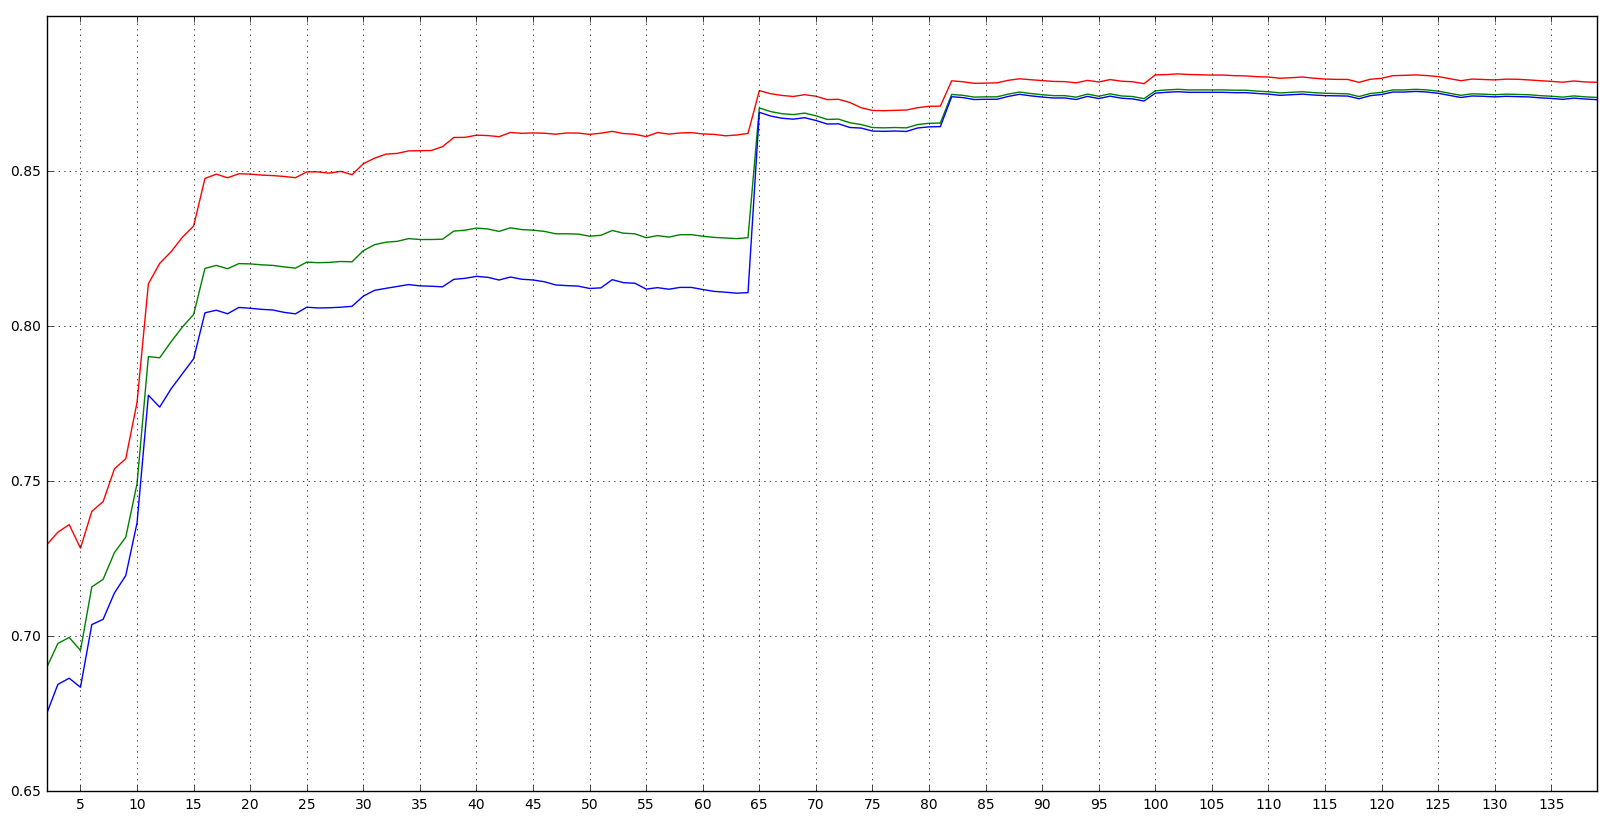

### Discussion 2 ###

SVM's classification performance for 16, 56, and 561 features are as follows:  
n_features: 16  t_train: 0.802sec  t_pred: 0.620sec  precision: 0.84 recall: 0.81  fscore: 0.79  
n_features: 56  t_train: 1.421sec  t_pred: 1.247sec  precision: 0.88  recall: 0.83  fscore: 0.81  
n_features: 561 t_train: 8.916sec  t_pred: 7.667sec  precision: 0.94 recall: 0.94  fscore: 0.94  

Using 16-feature reduced the training and testing time by more than 10 times while losing 10% classification performance measured as precision, recall and fscore. When compared to choosing 56 best features (top 10% of the whole feature vector), we see that 16-feature is almost as good as 56-feature in classification performance. 16-feature is twice faster than 56-feature in training and testing times.  

As 16-feature is good enough for SVM, now I will find ways to improve the classification performance by scaling, normalizing and outlier-removal. First, let's have a look at how the features are distributed by using a correlation matrix.

In [32]:
import scipy.stats.stats as st
skness = st.skew(Xs)

for skew, feature_name in zip(skness , Xs_cols.tolist()):
    print "skewness: {:+.2f}\t\t feature: ".format(skew) + feature_name

skewness: +0.60		 feature: tBodyAcc-max()-X
skewness: -1.63		 feature: tGravityAcc-mean()-X
skewness: -1.64		 feature: tGravityAcc-max()-X
skewness: -1.63		 feature: tGravityAcc-min()-X
skewness: -1.43		 feature: tGravityAcc-energy()-X
skewness: +0.11		 feature: tBodyAccJerk-entropy()-X
skewness: +0.17		 feature: tBodyAccJerk-entropy()-Z
skewness: +0.08		 feature: tBodyAccJerkMag-entropy()
skewness: +0.13		 feature: fBodyAcc-entropy()-X
skewness: +0.20		 feature: fBodyAccJerk-entropy()-X
skewness: +0.19		 feature: fBodyAccJerk-entropy()-Y
skewness: +0.27		 feature: fBodyAccJerk-entropy()-Z
skewness: +0.23		 feature: fBodyBodyAccJerkMag-entropy()
skewness: +1.42		 feature: angle(X,gravityMean)


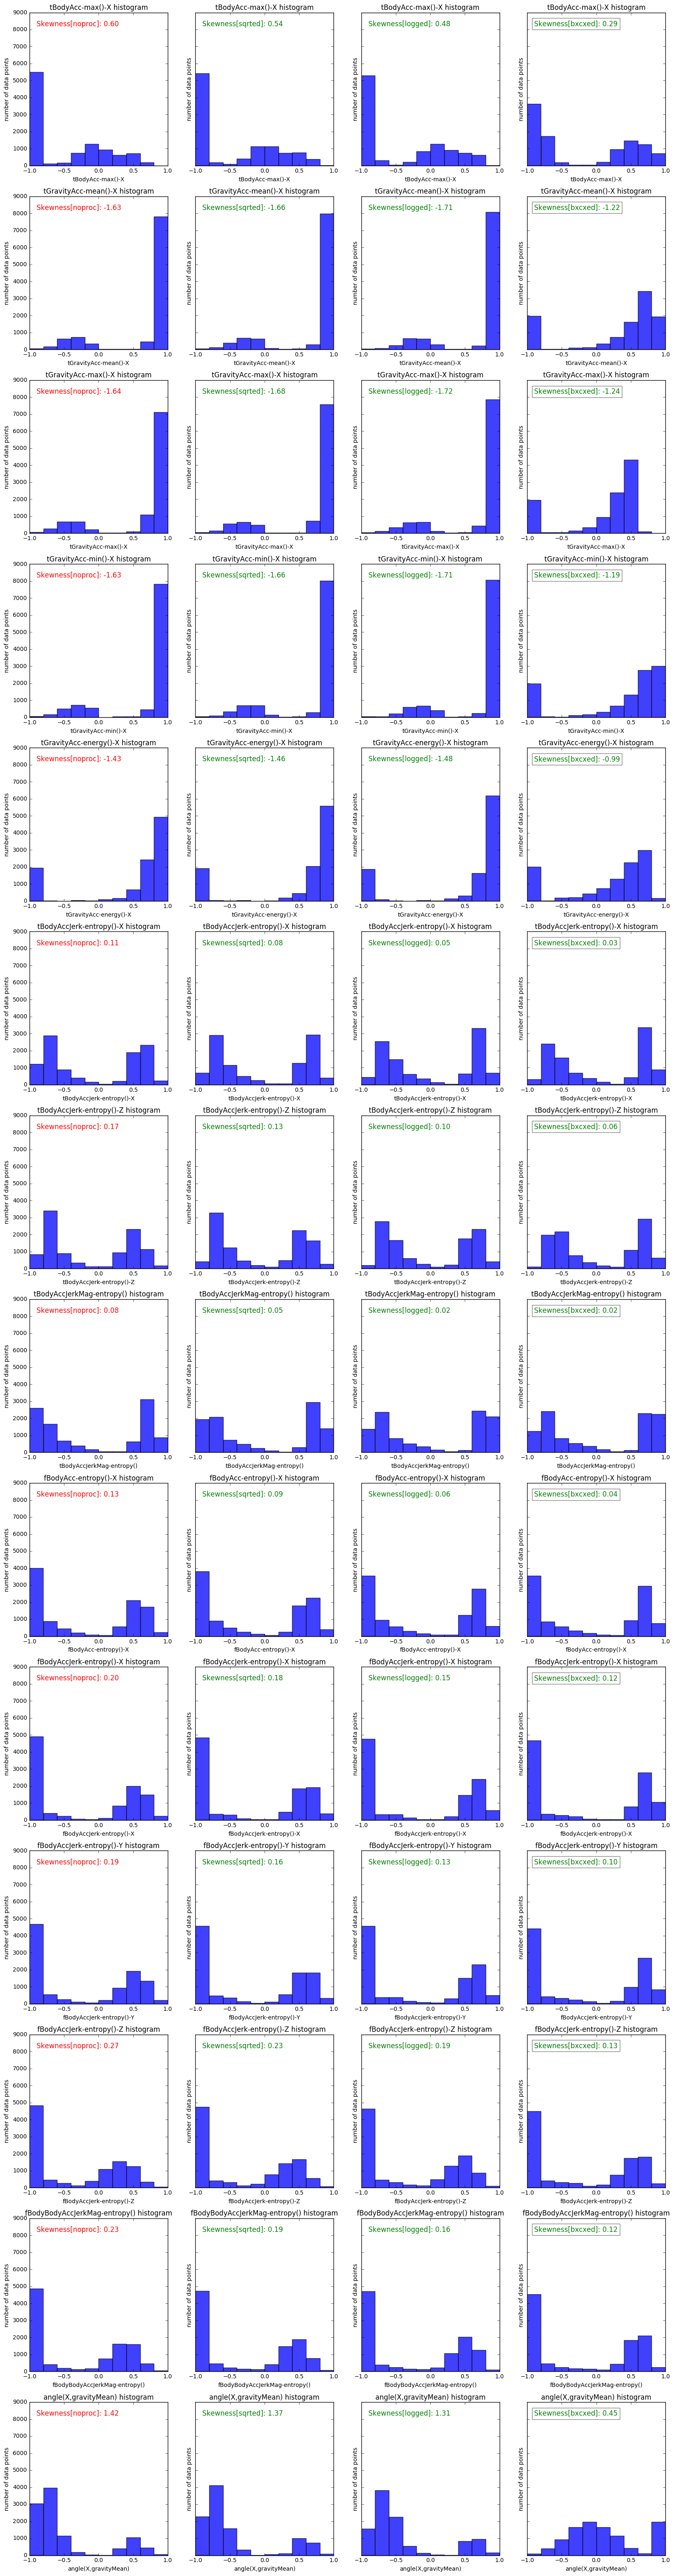

In [33]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from scipy.stats import boxcox

plt.rcParams['figure.figsize'] = (20.0, 80.0)
f, axarr = plt.subplots(len(Xs_cols.tolist()), 4, sharey=True)

preprocessing_names = ["noproc", "sqrted", "logged", "bxcxed"]

cnt = 0
for feature in Xs_cols.tolist():
    
    for i in range(4):
#         axarr[cnt, i].set_title( "[" + preprocessing_names[i] + "] "+ feature)
        axarr[cnt, i].set_title(feature + " histogram")
        axarr[cnt, i].set_xlabel(feature)
        axarr[cnt, i].set_ylabel("number of data points")
    
    Xs_feature = Xs[feature]
    skness = st.skew(Xs_feature)
    axarr[cnt, 0].hist(Xs_feature,facecolor='blue',alpha=0.75)
    axarr[cnt, 0].text(0.05, 0.95, 'Skewness[noproc]: {:.2f}'.format(skness), transform=axarr[cnt, 0].transAxes, 
                       fontsize=12, verticalalignment='top', color='red')
    
    Xs_feature_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs_feature)

    Xs_feature_sqrted = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.sqrt(Xs_feature_scaled))
#     Xs_feature_sqrted = preprocessing.scale(np.sqrt(Xs_feature_scaled))
    skness = st.skew(Xs_feature_sqrted)
    axarr[cnt, 1].hist(Xs_feature_sqrted,facecolor='blue',alpha=0.75)
    axarr[cnt, 1].text(0.05, 0.95, 'Skewness[sqrted]: {:.2f}'.format(skness), transform=axarr[cnt, 1].transAxes, 
                       fontsize=12, verticalalignment='top', color='green')
    
    Xs_feature_logged = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(np.log(Xs_feature_scaled))
#     Xs_feature_logged = preprocessing.scale(np.log(Xs_feature_scaled))
    skness = st.skew(Xs_feature_logged)
    axarr[cnt, 2].hist(Xs_feature_logged,facecolor='blue',alpha=0.75)
    axarr[cnt, 2].text(0.05, 0.95, 'Skewness[logged]: {:.2f}'.format(skness), transform=axarr[cnt, 2].transAxes, 
                       fontsize=12, verticalalignment='top', color='green')
    
    Xs_feature_bxcxed = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(boxcox(Xs_feature_scaled)[0])
#     Xs_feature_bxcxed = preprocessing.scale(boxcox(Xs_feature_scaled)[0])
    skness = st.skew(Xs_feature_bxcxed)
    axarr[cnt, 3].hist(Xs_feature_bxcxed,facecolor='blue',alpha=0.75)
    axarr[cnt, 3].text(0.05, 0.95, 'Skewness[bxcxed]: {:.2f}'.format(skness), transform=axarr[cnt, 3].transAxes, fontsize=12, 
                       verticalalignment='top', color='green',  bbox=dict(facecolor='white', alpha=0.5, boxstyle='square'))    
    cnt += 1

plt.show()

In [34]:
#NOTE: Tried robust scaler but it didn't have any effect on the dataset's skewness
Xs_rscaled = preprocessing.RobustScaler().fit_transform(Xs)
print Xs_rscaled.shape

for feature in range(Xs_rscaled.shape[1]):
    Xs_rscaled_feature = Xs_rscaled[:,feature]
    skness = st.skew(Xs_rscaled_feature)
    print "{:2d}".format(feature) + "  {:+.2f}".format(skness)

(10299L, 14L)
 0  +0.60
 1  -1.63
 2  -1.64
 3  -1.63
 4  -1.43
 5  +0.11
 6  +0.17
 7  +0.08
 8  +0.13
 9  +0.20
10  +0.19
11  +0.27
12  +0.23
13  +1.42


In [83]:
def boxCoxData(data):
    data_bxcxed = []
    for feature in range(data.shape[1]):
        data_bxcxed_feature, maxlog = boxcox(data[:,feature])
        if feature == 0:
            data_bxcxed = data_bxcxed_feature
        else:
            data_bxcxed = np.column_stack([data_bxcxed, data_bxcxed_feature])
    return data_bxcxed

def ScaleData(data):
    data_scaled = []
    for feature in range(data.shape[1]):
        data_scaled_feature = preprocessing.scale(data[:,feature])
        if feature == 0:
            data_scaled = data_scaled_feature
        else:
            data_scaled = np.column_stack([data_scaled, data_scaled_feature])
    return data_scaled

def testSVMPerformance(data_train, label_train, data_test, label_test, preprocess_method):
    
    if preprocess_method != "":
        data_train = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(data_train)
        data_test = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(data_test)
    
        if preprocess_method == "logged":
            data_train = np.log(data_train)
            data_test = np.log(data_test)
        elif preprocess_method == "sqrted":
            data_train = np.sqrt(data_train)
            data_test = np.sqrt(data_test)
        elif preprocess_method == "bxcxed":
            data_train = boxCoxData(data_train)
            data_test = boxCoxData(data_test)
            
        #this resulted in a more inferior performance compared to preprocessing.scale method
#         data_train = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(data_train)
#         data_test = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(data_test)

        data_train = ScaleData(data_train)
        data_test = ScaleData(data_test)        
        
    start = time()
    clf_SVM.fit(data_train, label_train)
    end = time()
    t_train = end - start
    #NOTE: For some reason this doesn't work here
#     t_train = train(clf_SVM, data_train, label_train)
    t_test, y_pred = predict(clf_SVM, data_test)
    precision, recall, fscore, support = precision_recall_fscore_support(label_test, y_pred, average='weighted')

    printout = preprocess_method
    if preprocess_method == "":
        printout = "noproc"
    
    printout += "  t_train: {:.3f}sec".format(t_train)
    printout += "  t_pred: {:.3f}sec".format(t_test)
    printout += "  precision: {:.2f}".format(precision)
    printout += "  recall: {:.2f}".format(recall)
    printout += "  fscore: {:.2f}".format(fscore)
    print printout

X_train_processed = X_train[Xs_cols]
X_test_processed = X_test[Xs_cols]

testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "scaled")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "logged")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "sqrted")
testSVMPerformance(X_train_processed, y_train['Activity'], X_test_processed, y_test['Activity'], "bxcxed")

noproc  t_train: 0.615sec  t_pred: 0.461sec  precision: 0.84  recall: 0.80  fscore: 0.78
scaled  t_train: 0.536sec  t_pred: 0.404sec  precision: 0.84  recall: 0.82  fscore: 0.81
logged  t_train: 0.550sec  t_pred: 0.420sec  precision: 0.84  recall: 0.82  fscore: 0.80
sqrted  t_train: 0.541sec  t_pred: 0.415sec  precision: 0.85  recall: 0.82  fscore: 0.81
bxcxed  t_train: 0.497sec  t_pred: 0.397sec  precision: 0.87  recall: 0.87  fscore: 0.87


It is time to test if there is any outlier in the boxcoxed dataset.

In [36]:
Xs_processed = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs)
Xs_bxcxed = boxCoxData(Xs_processed)
Xs_bxcxed_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(Xs_bxcxed)

outliers = []
for feature in range(Xs_bxcxed_scaled.shape[1]):
    Q1 = np.percentile(Xs_bxcxed_scaled[:, feature], 25)
    Q3 = np.percentile(Xs_bxcxed_scaled[:, feature], 75)
    step = 1.5 * (Q3 - Q1)

    outlier_filter = ~((Xs_bxcxed_scaled[:, feature] >= Q1 - step) & (Xs_bxcxed_scaled[:, feature] <= Q3 + step))
    
    cnt = 0
    for outlier in outlier_filter:
        if outlier:
            outliers.append(cnt)
        cnt += 1
    
# print "number of outliers with repeating indices: " + str(len(outliers))

id2cnt = {}
for outlier in outliers:
    if not outlier in id2cnt:
        id2cnt[outlier] = 1
    else:
        id2cnt[outlier] += 1
    
import operator
sorted_id2cnt = sorted(id2cnt.items(), key=operator.itemgetter(1), reverse=True)
cnt2nindices = {}
for key, value in sorted_id2cnt:
    #only remove the outliers that are repeated more than once
    if value <=1:
        break
    if not value in cnt2nindices:
        cnt2nindices[value] = 1
    else:
        cnt2nindices[value] += 1

for key, value in cnt2nindices.iteritems():
    print "{:2d} features share {:4d} potential outliers".format(key, value)

 2 features share   23 potential outliers
 3 features share 1953 potential outliers


Let's try to remove those 1953 potential outliers and test the performance of the SVM again. Although, this seems like losing too much data, I just want to see how this may effect the learning performance.

In [89]:
removed_outliers = []
for key, value in sorted_id2cnt:
    if value == 3:
        removed_outliers.append(key)
        
from sklearn import cross_validation
y_labels = y['Activity']

results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs.shape[0], n_folds=10, shuffle=False, random_state=42)
for train, test in kfold:
    clf_SVM.fit(Xs.iloc[train], y_labels.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs.iloc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

printout = "subsetsize: {:5d}".format(Xs.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout

Xs_filtered = Xs.drop(removed_outliers)
y_filtered = y.drop(removed_outliers)
y_filtered_labels = y_filtered['Activity'].to_frame()

Xs_filtered_proc = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs_filtered)
Xs_filtered_proc = boxCoxData(Xs_filtered_proc)
Xs_filtered_proc = ScaleData(Xs_filtered_proc)
Xs_filtered_proc = Xs_filtered_proc

results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs_filtered_proc.shape[0], n_folds=10, shuffle=False, random_state=42)  
for train, test in kfold:
    clf_SVM.fit(Xs_filtered_proc[train], y_filtered_labels.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs_filtered_proc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_filtered_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

print "**************"
printout = "subsetsize: {:5d}".format(Xs_filtered_proc.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout


results_precision = []
results_recall = []
results_fscore = []
kfold = cross_validation.KFold(Xs_filtered.shape[0], n_folds=10, shuffle=False, random_state=42)  
for train, test in kfold:
    clf_SVM.fit(Xs_filtered.iloc[train], y_filtered_labels.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
    t_test, y_pred = predict(clf_SVM, Xs_filtered.iloc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_filtered_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

printout = "subsetsize: {:5d}".format(Xs_filtered.shape[0])
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout

from random import sample
n_multiplier = Xs.shape[0]/500

for i in range(1, n_multiplier+1):
    subsetsize = i*500
    random_index = sample(range(0, Xs.shape[0]), subsetsize)
    
    Xs_subset = Xs.iloc[random_index]
    y_subset = y_labels.iloc[random_index].to_frame()

    results_precision = []
    results_recall = []
    results_fscore = []
    kfold = cross_validation.KFold(Xs_subset.shape[0], n_folds=10, shuffle=False, random_state=42)
    for train, test in kfold:
        clf_SVM.fit(Xs_subset.iloc[train], y_subset.iloc[train])
#         t_train = train(clf_SVM, Xs_subset.iloc[train], y_subset.iloc[train])
        t_test, y_pred = predict(clf_SVM, Xs_subset.iloc[test])
        precision, recall, fscore, support = precision_recall_fscore_support(y_subset.iloc[test], y_pred, 
                                                                             average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)

    printout = "subsetsize: {:5d}".format(subsetsize)
#     printout += "  t_train: {:.3f}sec".format(t_train)
#     printout += "  t_pred: {:.3f}sec".format(t_test)
    printout += "  precision: {:.2f}".format(np.mean(results_precision))
    printout += "  recall: {:.2f}".format(np.mean(results_recall))
    printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
    print printout
    
#TODO: TRY PCA
#TODO: merge featuers and re-run
#TODO: I guess that's it!

subsetsize: 10299  precision: 0.84  recall: 0.80  fscore: 0.78
**************
subsetsize:  8346  precision: 0.87  recall: 0.86  fscore: 0.86
subsetsize:  8346  precision: 0.80  recall: 0.76  fscore: 0.74
subsetsize:   500  precision: 0.85  recall: 0.79  fscore: 0.77
subsetsize:  1000  precision: 0.85  recall: 0.79  fscore: 0.76
subsetsize:  1500  precision: 0.84  recall: 0.79  fscore: 0.76
subsetsize:  2000  precision: 0.85  recall: 0.80  fscore: 0.77
subsetsize:  2500  precision: 0.85  recall: 0.79  fscore: 0.75
subsetsize:  3000  precision: 0.85  recall: 0.80  fscore: 0.77
subsetsize:  3500  precision: 0.87  recall: 0.81  fscore: 0.78
subsetsize:  4000  precision: 0.85  recall: 0.81  fscore: 0.79
subsetsize:  4500  precision: 0.84  recall: 0.81  fscore: 0.79
subsetsize:  5000  precision: 0.83  recall: 0.80  fscore: 0.79
subsetsize:  5500  precision: 0.84  recall: 0.80  fscore: 0.78
subsetsize:  6000  precision: 0.84  recall: 0.81  fscore: 0.79
subsetsize:  6500  precision: 0.84  reca

This shows that feature preprocessing and outlier removal are tied together. In other words, detected outliers are special to the space they are transformed to through preprocessing methods. Therefore, outliers in transformed space may not be outliers in the original space. Following results show that removing the outliers is only good if the learning is done on the space where those features transformed to.  

subsetsize:  8346  precision: 0.87  recall: 0.86  fscore: 0.86 (features are preprocessed)  
subsetsize:  8346  precision: 0.80  recall: 0.76  fscore: 0.74 (features are kept as the way they are)  

In [114]:
from sklearn.decomposition import PCA

# for n_components in range (2, 20):
for n_components in range (2, 400, 4):
    pca = PCA(n_components=n_components).fit(X)
#     print pca.explained_variance_ratio_
    printout = "n_components: {:d}".format(n_components)
    X_pcaed = pca.transform(X)
    
    results_precision = []
    results_recall = []
    results_fscore = []    
    kfold = cross_validation.KFold(X_pcaed.shape[0], n_folds=10, shuffle=False, random_state=42)
    for train, test in kfold:
        clf_SVM.fit(X_pcaed[train], y_labels.iloc[train])
        t_test, y_pred = predict(clf_SVM, X_pcaed[test])
        precision, recall, fscore, support = precision_recall_fscore_support(y_labels.iloc[test], y_pred, 
                                                                             average='weighted')
        results_precision.append(precision)
        results_recall.append(recall)
        results_fscore.append(fscore)

    printout += "  precision: {:.2f}".format(np.mean(results_precision))
    printout += "  recall: {:.2f}".format(np.mean(results_recall))
    printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
    print printout

n_components: 2  precision: 0.64  recall: 0.63  fscore: 0.61
n_components: 3  precision: 0.80  recall: 0.77  fscore: 0.76
n_components: 4  precision: 0.80  recall: 0.78  fscore: 0.77
n_components: 5  precision: 0.82  recall: 0.80  fscore: 0.80
n_components: 6  precision: 0.84  recall: 0.83  fscore: 0.82
n_components: 7  precision: 0.86  recall: 0.84  fscore: 0.84
n_components: 8  precision: 0.86  recall: 0.85  fscore: 0.85
n_components: 9  precision: 0.87  recall: 0.86  fscore: 0.86
n_components: 10  precision: 0.88  recall: 0.88  fscore: 0.88
n_components: 11  precision: 0.89  recall: 0.88  fscore: 0.88
n_components: 12  precision: 0.89  recall: 0.88  fscore: 0.88
n_components: 13  precision: 0.90  recall: 0.89  fscore: 0.89
n_components: 14  precision: 0.90  recall: 0.89  fscore: 0.89
n_components: 15  precision: 0.90  recall: 0.89  fscore: 0.89
n_components: 16  precision: 0.91  recall: 0.90  fscore: 0.90
n_components: 17  precision: 0.91  recall: 0.90  fscore: 0.90
n_components: 18

Let's combine best k features with pca's 19 components and train the SVM again.

In [118]:
#create dataframe for the first 19 components of the PCAed dataset
column_names = []
for i in range(X_pcaed.shape[1]):
    column_names.append("component{:2d}".format(i))

n_components = 19
pca = PCA(n_components=n_components).fit(X)
X_pcaed = pca.transform(X)
X_pcaed = pd.DataFrame(data=X_pcaed, index=range(X_pcaed.shape[0]), columns=column_names)
# print X_pcaed

In [135]:
#transform the features of X
Xs_scaled = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(Xs)
Xs_bxcxed = boxCoxData(Xs_scaled)
Xs_bxcxed = ScaleData(Xs_bxcxed)
# print Xs_bxcxed.shape
Xs_bxcxed = pd.DataFrame(data=Xs_bxcxed, index=range(Xs_bxcxed.shape[0]), columns=Xs_cols)
# print X_pcaed
# print Xs_bxcxed
# X_combined = Xs_bxcxed.add(X_pcaed, axis='columns')
# X_combined = Xs_bxcxed + X_pcaed

X_combined = pd.concat([Xs_bxcxed, X_pcaed], axis=1)

results_precision = []
results_recall = []
results_fscore = []    
kfold = cross_validation.KFold(X_combined.shape[0], n_folds=10, shuffle=False, random_state=42)
for train, test in kfold:
    clf_SVM.fit(X_combined.iloc[train], y_labels.iloc[train])
    t_test, y_pred = predict(clf_SVM, X_combined.iloc[test])
    precision, recall, fscore, support = precision_recall_fscore_support(y_labels.iloc[test], y_pred, 
                                                                         average='weighted')
    results_precision.append(precision)
    results_recall.append(recall)
    results_fscore.append(fscore)

printout = "combined"
printout += "  precision: {:.2f}".format(np.mean(results_precision))
printout += "  recall: {:.2f}".format(np.mean(results_recall))
printout += "  fscore: {:.2f}".format(np.mean(results_fscore))
print printout

combined  precision: 0.92  recall: 0.91  fscore: 0.91


In [150]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

def boxCoxData(data):
    data_bxcxed = []
    for feature in range(data.shape[1]):
        data_bxcxed_feature, maxlog = boxcox(data[:,feature])
        if feature == 0:
            data_bxcxed = data_bxcxed_feature
        else:
            data_bxcxed = np.column_stack([data_bxcxed, data_bxcxed_feature])
    return data_bxcxed

def ScaleData(data):
    data_scaled = []
    for feature in range(data.shape[1]):
        data_scaled_feature = preprocessing.scale(data[:,feature])
        if feature == 0:
            data_scaled = data_scaled_feature
        else:
            data_scaled = np.column_stack([data_scaled, data_scaled_feature])
    return data_scaled

def predict(clf, features):
    start = time()
    pred = clf.predict(features)
    end = time()
    return end - start, pred

# kbest_param_vals = [5, 10, 15, 20, 30, 50, 100, 200, Xs.shape[1]]
kbest_param_vals = [X.shape[1]]
pca_n_components = [2, 5, 10, 15, 20, 30, 40, 50, 100, 200, 400]

for kbest in kbest_param_vals:
    start = time()
    #choose kbest feature dimensions
    f_selector = SelectKBest(k=kbest)
    X_slctd = f_selector.fit(X, y['Activity']).transform(X)
    f_selected_indices = f_selector.get_support(indices=False)
    X_slctd_cols = X.columns[f_selected_indices]
    
    #transform these features to another space where they are less skewed
    X_slctd_tformed = preprocessing.MinMaxScaler(feature_range=(1, 2), copy=True).fit_transform(X_slctd)
    X_slctd_tformed = boxCoxData(X_slctd_tformed)
    X_slctd_tformed = preprocessing.MinMaxScaler(feature_range=(-1, 1), copy=True).fit_transform(X_slctd_tformed)
    X_slctd_tformed = pd.DataFrame(data=X_slctd_tformed, index=range(X_slctd_tformed.shape[0]), columns=X_slctd_cols)
    end = time()
    
    for pca_n in pca_n_components:
        column_names = []
        for i in range(pca_n):
            column_names.append("component{:2d}".format(i))
            
        start_pca = time()
        pca = PCA(n_components=pca_n).fit(X)
        X_pcaed = pca.transform(X)
        X_pcaed = pd.DataFrame(data=X_pcaed, index=range(X_pcaed.shape[0]), columns=column_names)
        
        X_combined = pd.concat([X_slctd_tformed, X_pcaed], axis=1)
        end_pca = time()
        t_proc = (end - start) + (end_pca - start_pca)
        results_precision = []
        results_recall = []
        results_fscore = []
        kfold = cross_validation.KFold(X_combined.shape[0], n_folds=10, shuffle=False, random_state=42)
        t_trains = []
        t_tests = []
        for train, test in kfold:
            t_train_s = time()
            clf_SVM.fit(X_combined.iloc[train], y_labels.iloc[train])
            t_trains.append( time() - t_train_s )
            t_test, y_pred = predict(clf_SVM, X_combined.iloc[test])
            t_tests.append(t_test)
            precision, recall, fscore, support = precision_recall_fscore_support(y_labels.iloc[test], y_pred, 
                                                                                 average='weighted')
            results_precision.append(precision)
            results_recall.append(recall)
            results_fscore.append(fscore)

        printout = "(kbest{:3d})(pca_n{:3d})".format(kbest, pca_n)
        printout += "  precision: {:.2f}".format(np.mean(results_precision))
        printout += "  recall: {:.2f}".format(np.mean(results_recall))
        printout += "  fscore: {:.2f}\t".format(np.mean(results_fscore))
        printout += "  t_proc: {:.2f}  t_train: {:.2f}  t_test: {:.2f}".format(t_proc, np.mean(t_trains), np.mean(t_tests))
        print printout

(kbest561)(pca_n  2)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 13.97  t_train: 8.25  t_test: 2.07
(kbest561)(pca_n  5)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 13.96  t_train: 7.73  t_test: 1.95
(kbest561)(pca_n 10)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 13.96  t_train: 7.62  t_test: 1.92
(kbest561)(pca_n 15)  precision: 0.94  recall: 0.93  fscore: 0.93	  t_proc: 14.00  t_train: 7.61  t_test: 1.92
(kbest561)(pca_n 20)  precision: 0.94  recall: 0.94  fscore: 0.93	  t_proc: 14.00  t_train: 7.80  t_test: 1.98
(kbest561)(pca_n 30)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 14.06  t_train: 7.88  t_test: 1.98
(kbest561)(pca_n 40)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 14.03  t_train: 7.97  t_test: 2.00
(kbest561)(pca_n 50)  precision: 0.94  recall: 0.94  fscore: 0.94	  t_proc: 14.12  t_train: 8.23  t_test: 2.05
(kbest561)(pca_n100)  precision: 0.95  recall: 0.94  fscore: 0.94	  t_proc: 14.07  t_train: 8.77  t_test: 2.20
(

In [75]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    return r2_score(y_true, y_predict)

from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):

    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    params = {'max_depth': range(1,20)}
    
    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    regressor = DecisionTreeRegressor(max_depth = params['max_depth'], random_state=42)
    grid = GridSearchCV(regressor, param_grid=params, scoring=scoring_fnc)
    grid = grid.fit(X, y)
    return grid.best_estimator_

# clf = fit_model(X,y)
clf = fit_model(X_train,y_train)

print clf.score(X_train, y_train)
print clf.score(X_test, y_test)

0.962090475252
0.935622077259


[ 0.62227069  0.04772595]
(7352, 561)
(7352L, 2L)
(7352, 2)


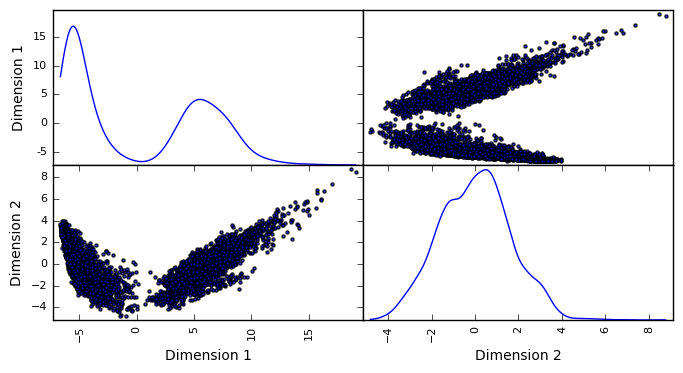

In [76]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components).fit(X)
print pca.explained_variance_ratio_

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(X_train)
print X_train.shape
print reduced_data.shape

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
print reduced_data.shape

# Produce a scatter matrix for pca reduced data
pd.scatter_matrix(reduced_data, alpha = 0.8, figsize = (8,4), diagonal = 'kde');

In [77]:
for n_components in range (2, 20):
    pca = PCA(n_components=n_components).fit(X)
#     print pca.explained_variance_ratio_

    Xr_train = pca.transform(X_train)
    clf = fit_model(Xr_train,y_train)

    Xr_test = pca.transform(X_test)

    print "ncomponents:" + str(n_components) + "  " + str(clf.score(Xr_train, y_train)) + "  " + str(clf.score(Xr_test, y_test))

ncomponents:2  0.829794609821  0.817523751705
ncomponents:3  0.914622785147  0.880681546984
ncomponents:4  0.916132496275  0.883332684222
ncomponents:5  0.915014128249  0.883337137198
ncomponents:6  0.948212219624  0.91029743867
ncomponents:7  0.9598514494  0.896908394552
ncomponents:8  0.941559320352  0.89628029853
ncomponents:9  0.944060646562  0.900224728879
ncomponents:10  0.957566335249  0.907230067588
ncomponents:11  0.946434966363  0.903618561286
ncomponents:12  0.945678613906  0.900804093453
ncomponents:13  0.965382265608  0.906169049642
ncomponents:14  0.930898078535  0.89379185418
ncomponents:15  0.965953007253  0.907865387419
ncomponents:16  0.958208838252  0.901460035336
ncomponents:17  0.9316025583  0.8929043262
ncomponents:18  0.9316025583  0.891671540028
ncomponents:19  0.9316025583  0.891447397087
